In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import shap
import logging

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Preprocessing

In [4]:
file_names = ["clinical_tcga_kirc.tsv", "clinical_tcga_kich.tsv", "clinical_kidney.tsv"]

# Initialize an empty DataFrame
all_data_df = pd.DataFrame()

# Iterate through the file names and read each file excluding the last 5 rows
for file_name in file_names:
    try:
        current_df = pd.read_csv(file_name, sep='\t')  # Read the entire file
        current_df.replace('\'--', np.nan, inplace=True)

        # Exclude the last 5 rows
        current_df = current_df.iloc[:-5]

        # Concatenate the current DataFrame with the combined DataFrame
        all_data_df = pd.concat([all_data_df, current_df], ignore_index=True)
        print("Number of rows in " + file_name + " df (excluding last 5 rows):", current_df.shape[0])
        
    except FileNotFoundError:
        print(f"The file '{file_name}' does not exist.")
    except Exception as e:
        print(f"An error occurred while processing '{file_name}': {e}")

# Check the percentage of null values in the 'days_to_death' column
null_percentage_days_to_death = (all_data_df['days_to_death'].isnull().sum() / len(all_data_df['days_to_death'])) * 100

# Print the result
print(f"Percentage of null values in 'days_to_death': {null_percentage_days_to_death:.2f}%")

# Check the percentage of patients with 'alive' in 'vital_status'
percentage_alive = (all_data_df['vital_status'].value_counts(normalize=True) * 100).get('Alive', 0)

# Print the result
print(f"Percentage of patients with 'alive' in 'vital_status': {percentage_alive:.2f}%")

all_features_in_original_data = all_data_df.columns


Number of rows in clinical_tcga_kirc.tsv df (excluding last 5 rows): 1069
Number of rows in clinical_tcga_kich.tsv df (excluding last 5 rows): 221
Number of rows in clinical_kidney.tsv df (excluding last 5 rows): 4465
Percentage of null values in 'days_to_death': 81.75%
Percentage of patients with 'alive' in 'vital_status': 55.34%


In [5]:
# Exclude 'days_to_death' from the columns considered for dropping
columns_to_drop = all_data_df.columns[all_data_df.columns != 'days_to_death']  # Exclude 'days_to_death'
columns_to_drop = columns_to_drop[(all_data_df[columns_to_drop].isna().mean() > 0.9)]  # Check for NaN values

# Drop columns
all_data_df = all_data_df.drop(columns=columns_to_drop)

all_data_df1 = all_data_df.copy()



#### PCA density plot creation

In [4]:
# Copy dataset
pca_df = all_data_df.copy()

# Drop rows with missing values in the target variable
pca_df = pca_df.dropna(subset=['ajcc_pathologic_stage'])

# Extract features and target variable
X_pca = pca_df.drop(columns=['ajcc_pathologic_stage'])
y_pca = pca_df['ajcc_pathologic_stage']

# Keep only the columns with non-null values
X_pca = X_pca.loc[:, X_pca.notnull().all()]

print(X_pca)

                                   case_id case_submitter_id project_id  \
0     0022478c-4dfd-4cbe-a05e-fb20310844e3      TCGA-B0-5088  TCGA-KIRC   
1     0022478c-4dfd-4cbe-a05e-fb20310844e3      TCGA-B0-5088  TCGA-KIRC   
2     01277e9d-a35f-45d9-9e60-2e8cd79630a0      TCGA-DV-A4W0  TCGA-KIRC   
3     01277e9d-a35f-45d9-9e60-2e8cd79630a0      TCGA-DV-A4W0  TCGA-KIRC   
4     0242658f-a698-4e68-b6e3-2f4aa076763e      TCGA-BP-4162  TCGA-KIRC   
...                                    ...               ...        ...   
5747  ff9328d5-d604-4276-866c-2d44ef3b2403      TCGA-BP-4176  TCGA-KIRC   
5748  ff9328d5-d604-4276-866c-2d44ef3b2403      TCGA-BP-4176  TCGA-KIRC   
5750  ffad76a6-045c-4005-9088-6deb8b83f0ec         C3N-02261    CPTAC-3   
5752  ffb88267-1a97-41c9-ae25-6c6cefaf9dd9      TCGA-BP-5190  TCGA-KIRC   
5753  ffb88267-1a97-41c9-ae25-6c6cefaf9dd9      TCGA-BP-5190  TCGA-KIRC   

                   ethnicity  gender                       race vital_status  \
0     not hispanic 

In [3]:

# Copy dataset
pca_df = all_data_df.copy()

# Drop rows with missing values in the target variable
pca_df = pca_df.dropna(subset=['ajcc_pathologic_stage'])

# Extract features and target variable
X_pca = pca_df.drop(columns=['ajcc_pathologic_stage'])
y_pca = pca_df['ajcc_pathologic_stage']

# Keep only the columns with non-null values
X_pca = X_pca.loc[:, X_pca.notnull().all()]

print(X_pca)

                                   case_id case_submitter_id project_id  \
1878  23f9ba79-3234-4025-92a8-5dcd28971593         C3N-00435    CPTAC-3   
841   cf77fe39-0b4a-4b38-b563-2a244b9fb5c0      TCGA-B0-4845  TCGA-KIRC   
4809  ce0f2e87-6c46-45b5-8df7-3ba32e48ce52      TCGA-2Z-A9JG  TCGA-KIRP   
4227  a8db1341-a7fc-4306-91ad-5caaca5c8a6e      TCGA-CJ-4912  TCGA-KIRC   
875   d62d39f9-c896-4758-a785-e236f0154f14      TCGA-B8-5162  TCGA-KIRC   
...                                    ...               ...        ...   
2200  366219b9-fde3-4d2d-82d3-15fe6245aa98      TCGA-KN-8429  TCGA-KICH   
5407  ed560804-50b9-488e-bfa9-33f20cb83106      TCGA-BQ-5890  TCGA-KIRP   
4508  b9fc9eff-1228-482d-87a2-ebbb5c92733a      TCGA-BP-5191  TCGA-KIRC   
3971  9ab5714c-19bc-4022-b1ce-ef18ee2a9cb2      TCGA-BQ-5880  TCGA-KIRP   
4110  a2663a86-a006-4867-9e88-2b523df48303      TCGA-B8-A54K  TCGA-KIRC   

                   ethnicity  gender                       race vital_status  \
1878            not

Number of components selected to explain 95.0% variance: 663
Number of anomalies: 226
Number of non-anomalies: 788


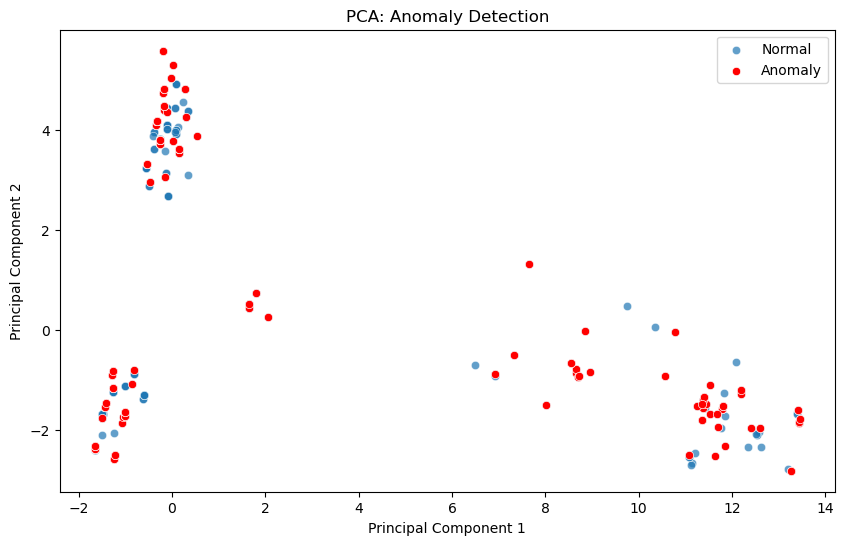

In [4]:
# Encode the target variable 'ajcc_pathologic_stage'
le = LabelEncoder()
y_pca = le.fit_transform(y_pca)

# Encode categorical variables (assuming all non-numeric columns are categorical)
X_pca = pd.get_dummies(X_pca)

# Handle any remaining missing values after one-hot encoding
X_pca = X_pca.dropna()

# Standardize the features
scaler = StandardScaler()
X_pca_std = scaler.fit_transform(X_pca)

# Apply Principal Component Analysis (PCA)
pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca_std)

# Determine the number of components to explain a certain percentage of variance (e.g., 95%)
target_explained_variance = 0.95
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= target_explained_variance) + 1

# Print the number of components selected
print(f"Number of components selected to explain {target_explained_variance * 100}% variance: {n_components}")

# Use the selected number of components for further analysis or modeling
X_selected = X_pca_transformed[:, :n_components]

# Calculate reconstruction error for anomaly detection
X_reconstructed = np.dot(X_selected, pca.components_[:n_components, :])
reconstruction_error = np.sum((X_pca_std - X_reconstructed)**2, axis=1)

# Set anomaly threshold (you may adjust this based on your analysis)
anomaly_threshold = 100.0  

# Identify anomalies
anomalies = (reconstruction_error > anomaly_threshold)

# Visualize anomalies in a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of the first two principal components
sns.scatterplot(x=X_selected[:, 0], y=X_selected[:, 1], label='Normal', alpha=0.7)

# Highlight anomalies
anomaly_indices = np.where(anomalies)[0]
sns.scatterplot(x=X_selected[anomaly_indices, 0], y=X_selected[anomaly_indices, 1], label='Anomaly', color='red')


# Count anomalies
num_anomalies = np.sum(anomalies)

# Count non-anomalies
num_non_anomalies = len(anomalies) - num_anomalies

# Print the counts
print(f"Number of anomalies: {num_anomalies}")
print(f"Number of non-anomalies: {num_non_anomalies}")


plt.title('PCA: Anomaly Detection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Number of components selected to explain 95.0% variance: 663
Number of anomalies: 226
Number of non-anomalies: 788


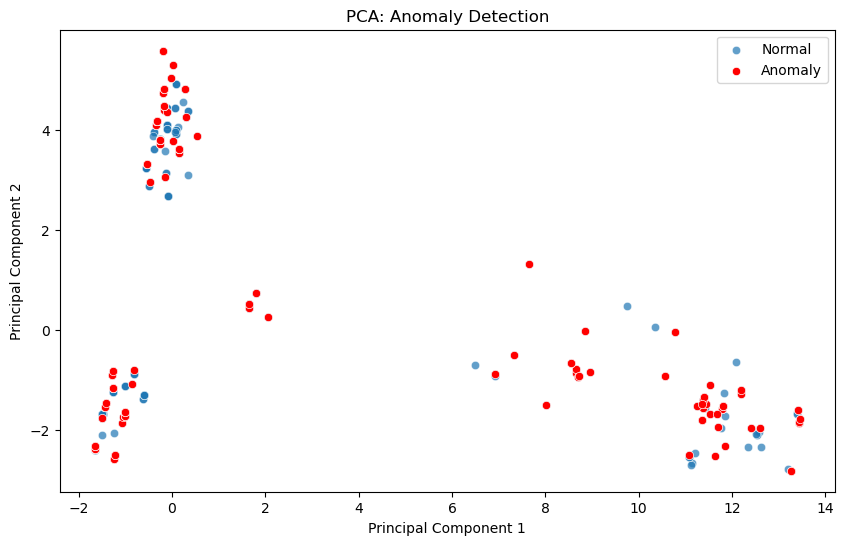

In [5]:
# Encode the target variable 'ajcc_pathologic_stage'
le = LabelEncoder()
y_pca = le.fit_transform(y_pca)

# Encode categorical variables (assuming all non-numeric columns are categorical)
X_pca = pd.get_dummies(X_pca)

# Handle any remaining missing values after one-hot encoding
X_pca = X_pca.dropna()

# Standardize the features
scaler = StandardScaler()
X_pca_std = scaler.fit_transform(X_pca)

# Apply Principal Component Analysis (PCA)
pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca_std)

# Determine the number of components to explain a certain percentage of variance (e.g., 95%)
target_explained_variance = 0.95
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= target_explained_variance) + 1

# Print the number of components selected
print(f"Number of components selected to explain {target_explained_variance * 100}% variance: {n_components}")

# Use the selected number of components for further analysis or modeling
X_selected = X_pca_transformed[:, :n_components]

# Calculate reconstruction error for anomaly detection
X_reconstructed = np.dot(X_selected, pca.components_[:n_components, :])
reconstruction_error = np.sum((X_pca_std - X_reconstructed)**2, axis=1)

# Set anomaly threshold (you may adjust this based on your analysis)
anomaly_threshold = 100.0  

# Identify anomalies
anomalies = (reconstruction_error > anomaly_threshold)

# Visualize anomalies in a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of the first two principal components
sns.scatterplot(x=X_selected[:, 0], y=X_selected[:, 1], label='Normal', alpha=0.7)

# Highlight anomalies
anomaly_indices = np.where(anomalies)[0]
sns.scatterplot(x=X_selected[anomaly_indices, 0], y=X_selected[anomaly_indices, 1], label='Anomaly', color='red')


# Count anomalies
num_anomalies = np.sum(anomalies)

# Count non-anomalies
num_non_anomalies = len(anomalies) - num_anomalies

# Print the counts
print(f"Number of anomalies: {num_anomalies}")
print(f"Number of non-anomalies: {num_non_anomalies}")


plt.title('PCA: Anomaly Detection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


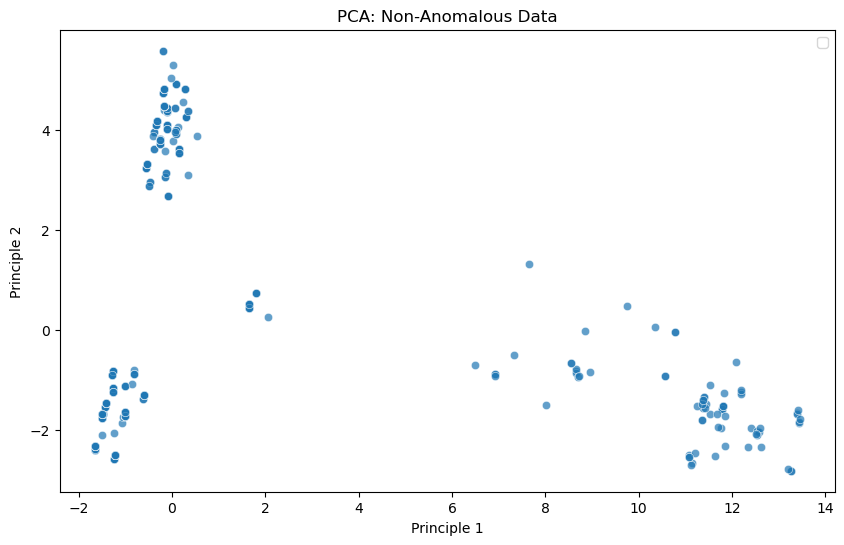

In [6]:
non_anomalous_data = X_pca[~anomalies]

component_names = [f"Principal Component {i+1}" for i in range(pca.n_components_)]

loadings_df = pd.DataFrame(pca.components_, columns=X_pca.columns, index=component_names)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_selected[:, 0], y=X_selected[:, 1], alpha=0.7)

plt.title('PCA: Non-Anomalous Data')
plt.xlabel('Principle 1')
plt.ylabel('Principle 2')
plt.legend()
plt.show()

In [7]:
component_names = ["Principal Component 1", "Principal Component 2"]
loadings_df = pd.DataFrame(pca.components_[:2, :], columns=X_pca.columns, index=component_names)


# Display the top features contributing to each principal component
for component in component_names:
    top_features = loadings_df.loc[component].sort_values(ascending=False).index[:3]
    print(f"{component} Top Features: {', '.join(top_features)}")

Principal Component 1 Top Features: project_id_CPTAC-3, progression_or_recurrence_no, primary_diagnosis_Renal cell carcinoma, NOS
Principal Component 2 Top Features: project_id_TCGA-KIRP, primary_diagnosis_Papillary adenocarcinoma, NOS, morphology_8260/3


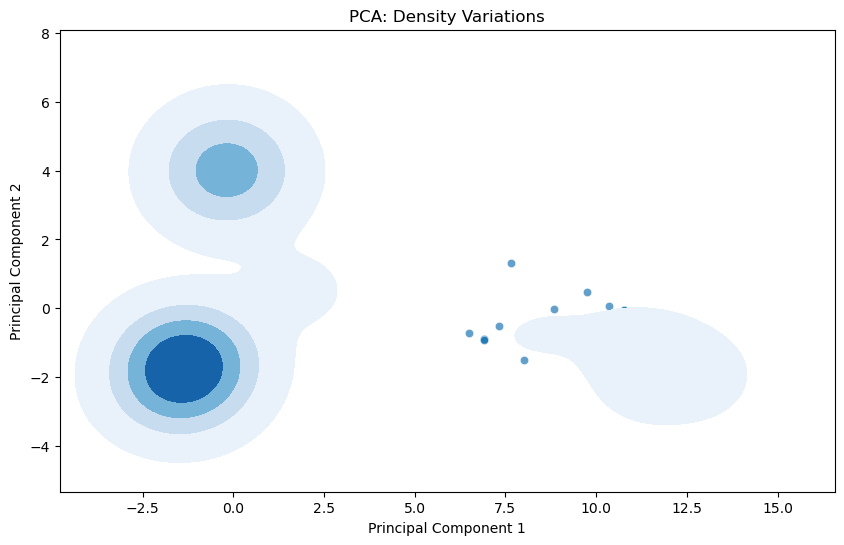

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_selected[:, 0], y=X_selected[:, 1], alpha=0.7)
sns.kdeplot(x=X_selected[:, 0], y=X_selected[:, 1], cmap="Blues", fill=True, levels=5)

plt.title('PCA: Density Variations')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### simple plot to show alive v deceased patients in the data

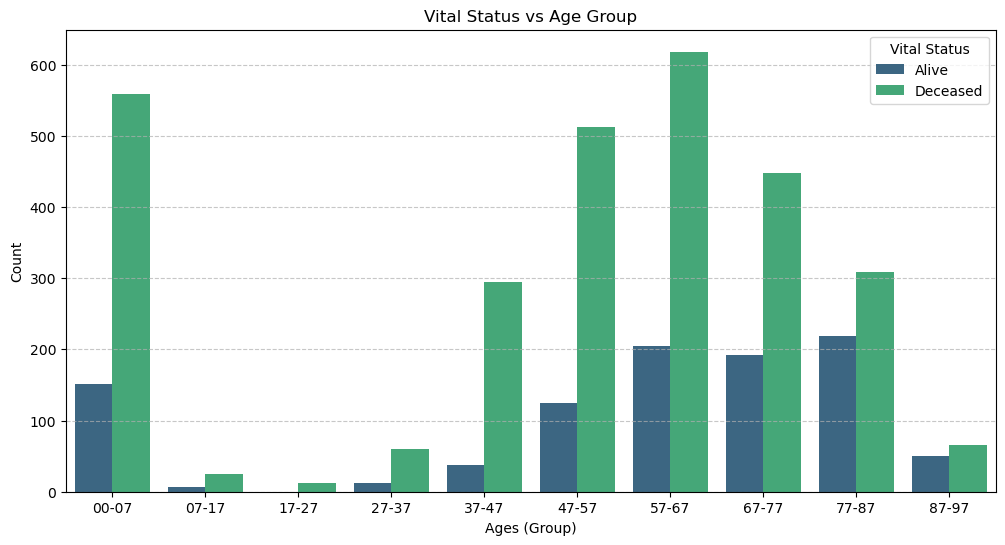

In [6]:
# Drop rows where 'vital_status' is "unknown"
all_data_df1 = all_data_df1[all_data_df1['vital_status'] != 'Unknown']

# Convert 'age_at_index' column to numeric
all_data_df1['age_at_index'] = pd.to_numeric(all_data_df1['age_at_index'], errors='coerce')

# Drop rows where 'age_at_index' is NaN
all_data_df1 = all_data_df1.dropna(subset=['age_at_index', 'vital_status'])

# Create 10 equal-width bins for 'age_at_index'
bins = np.linspace(all_data_df1['age_at_index'].min(), all_data_df1['age_at_index'].max(), 11)

# Define custom age group labels
age_group_labels = ["00-07","07-17", "17-27", "27-37", "37-47", "47-57", "57-67", "67-77", "77-87", "87-97"]

# Use pd.cut to assign each value to a bin with custom labels
all_data_df1['age_group'] = pd.cut(all_data_df1['age_at_index'], bins=bins, right=False, labels=age_group_labels)

# Plot 'vital_status' against 'age_group'
plt.figure(figsize=(12, 6))
sns.countplot(x='age_group', hue='vital_status', data=all_data_df1, palette='viridis')
plt.title('Vital Status vs Age Group')
plt.xlabel('Ages (Group)')
plt.ylabel('Count')

# Add Legend
plt.legend(title='Vital Status', loc='upper right', labels=['Alive', 'Deceased'])

# Add Grid Lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:
# Copy the 'days_to_death' column to a new DataFrame
median_df = all_data_df.copy()

# Convert 'days_to_death' to numeric, handling errors by coercing to NaN
median_df['days_to_death'] = pd.to_numeric(median_df['days_to_death'], errors='coerce')

# Drop rows with null values in the 'days_to_death' column
median_df = median_df.dropna(subset=['days_to_death'])

# Calculate the median of the 'days_to_death' column
median_days_to_death = median_df['days_to_death'].median()

# Create a new column 'survivability_category' based on the median
median_df['survivability_category'] = np.where(median_df['days_to_death'] > median_days_to_death, 'high', 'low')

df_sc = median_df.copy()



## Isolation Forest for removing anomalies

In [8]:
features = ['days_to_death', 'age_at_index']

# Create a DataFrame for anomaly detection
anomaly_df = df_sc[features + ['race', 'gender']].copy()

# Convert 'days_to_death' to numeric, handling errors by coercing to NaN
anomaly_df['days_to_death'] = pd.to_numeric(anomaly_df['days_to_death'], errors='coerce')

# Drop rows with null values in the features
anomaly_df = anomaly_df.dropna(subset=features)

# Initialize Isolation Forest
isolation_forest = IsolationForest(contamination=0.05)

# Fit the model and predict anomalies
anomaly_df['is_anomaly'] = isolation_forest.fit_predict(anomaly_df[features])

# Count the number of removed points
removed_points = anomaly_df['is_anomaly'].value_counts().get(-1, 0)

# Filter out anomalies (keeping only non-anomalous data)
filtered_df = anomaly_df[anomaly_df['is_anomaly'] != -1].drop(columns=['is_anomaly'])

# Count the number of remaining points
remaining_points = len(filtered_df)

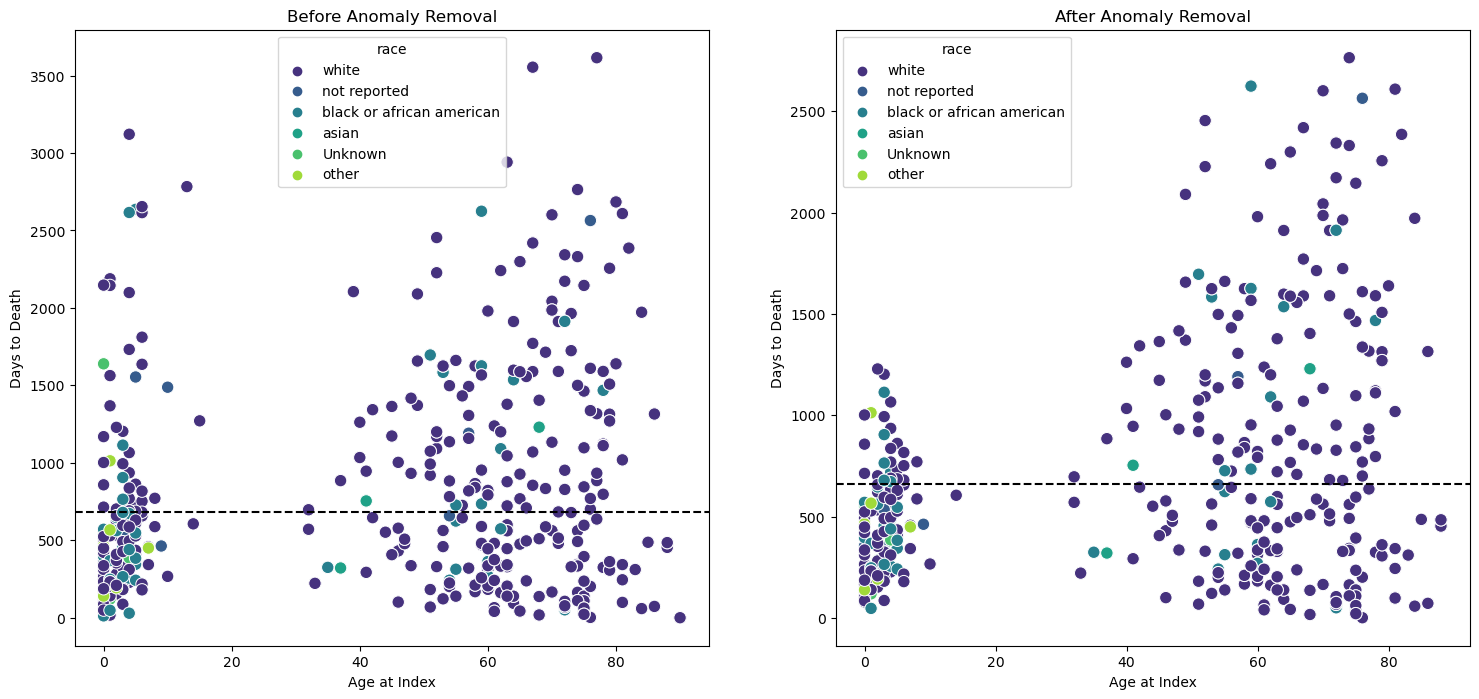

Remaining points:  951
Removed points:  49


In [9]:
# Plotting before/after Isolation Forest
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='age_at_index', y='days_to_death', hue='race', data=anomaly_df, palette='viridis', s=80)
plt.axhline(y=anomaly_df['days_to_death'].median(), color='black', linestyle='--', label=f'Median: {anomaly_df["days_to_death"].median()}')
plt.xlabel('Age at Index')
plt.ylabel('Days to Death')
plt.title('Before Anomaly Removal')


plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='age_at_index', y='days_to_death', hue='race', data=filtered_df, palette='viridis', s=80)
plt.axhline(y=filtered_df['days_to_death'].median(), color='black', linestyle='--', label=f'Median: {filtered_df["days_to_death"].median()}')
plt.xlabel('Age at Index')
plt.ylabel('Days to Death')
plt.title('After Anomaly Removal')

plt.show()

print("Remaining points: ", remaining_points)
print("Removed points: ", removed_points)

## Show high/low survivabilty based on the median of days_to_death

In [10]:
# Copy the 'days_to_death' column to a new DataFrame
median_df = filtered_df[['days_to_death', 'age_at_index', 'gender', 'race']].copy()

# Convert 'days_to_death' to numeric, handling errors by coercing to NaN
median_df['days_to_death'] = pd.to_numeric(median_df['days_to_death'], errors='coerce')

# Drop rows with null values in the 'days_to_death' column
median_df = median_df.dropna(subset=['days_to_death'])


# Calculate the median of the 'days_to_death' column
median_days_to_death = median_df['days_to_death'].median()

# Create a new column 'survivability_category' based on the median
median_df['survivability_category'] = np.where(median_df['days_to_death'] > median_days_to_death, 'high', 'low')

df2 = median_df.copy()

print(median_df)

      days_to_death age_at_index  gender                       race  \
0             563.0           53    male                      white   
1             563.0           53    male                      white   
10            344.0           74  female                      white   
11            344.0           74  female                      white   
12           1657.0           49  female                      white   
...             ...          ...     ...                        ...   
5649          375.0           61    male                      white   
5654          440.0            4  female  black or african american   
5707          680.0            3  female  black or african american   
5741         1588.0           65    male                      white   
5742         1588.0           65    male                      white   

     survivability_category  
0                       low  
1                       low  
10                      low  
11                      low

In [11]:
survivability_counts = df2['survivability_category'].value_counts()

high_survivability_count = survivability_counts.get('high', 0)
low_survivability_count = survivability_counts.get('low', 0)

print(f'High Survivability Count: {high_survivability_count}')
print(f'Low Survivability Count: {low_survivability_count}')


High Survivability Count: 475
Low Survivability Count: 476


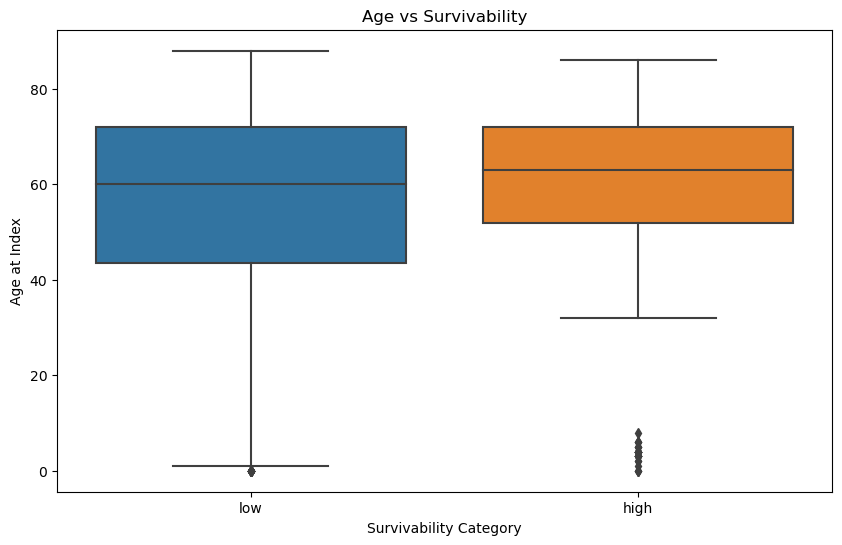

In [12]:
median_df['age_at_index'] = pd.to_numeric(median_df['age_at_index'], errors='coerce')

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='survivability_category', y='age_at_index', data=median_df)
plt.title('Age vs Survivability')
plt.xlabel('Survivability Category')
plt.ylabel('Age at Index')
plt.show()

**predicting survivabilty of a newly entered patient based of race and age**

In [16]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)


# Ensure the 'survivability_category' column is of type string or categorical
df_sc['survivability_category'] = df_sc['survivability_category'].astype(str)

# Separate features and target variable
features = df_sc[['age_at_index', 'gender', 'race']]
labels = df_sc['survivability_category']

# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
features['race'] = label_encoder.fit_transform(features['race'])
features['gender'] = label_encoder.fit_transform(features['gender'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)

    # Initialize a Random Forest classifier with hyperparameters
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=22
    )

    # Train the model
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    rf_predictions = rf_classifier.predict(X_test)

    # Evaluate the model (you can use any appropriate metric)
    accuracy = accuracy_score(y_test, rf_predictions)

    return 1.0 - accuracy 

# Create a study object and optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) 

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Use the best hyperparameters to train the final model
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

final_model = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)

final_model.fit(X_train, y_train)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Best Hyperparameters: {'n_estimators': 110, 'max_depth': 21, 'min_samples_split': 0.24681449022053525, 'min_samples_leaf': 0.15802076519522396}


RandomForestClassifier(max_depth=21, min_samples_leaf=0.15802076519522396,
                       min_samples_split=0.24681449022053525, n_estimators=110,
                       random_state=42)

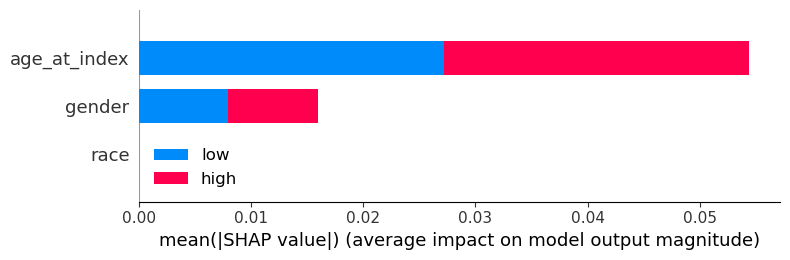

In [17]:
# SHAP analysis for the final model
explainer = shap.TreeExplainer(final_model)
shap_values_final = explainer.shap_values(X_test)

# Create a mapping dictionary for class names
class_mapping = {
    '0': 'high',
    '1': 'low',
    # Add more mappings as needed
}

# Summary plot for the final model with custom class names
shap.summary_plot(shap_values_final, X_test, feature_names=features.columns, class_names=list(class_mapping.values()), show=False)
plt.show()

In [18]:
# Evaluate the final model
final_accuracy = accuracy_score(y_test, final_predictions)
print(f'Final Accuracy: {final_accuracy:.2f}')

# Print final classification report
print('Final Classification Report:\n', classification_report(y_test, final_predictions))


Final Accuracy: 0.55
Final Classification Report:
               precision    recall  f1-score   support

        high       0.50      0.85      0.63        91
         low       0.69      0.29      0.41       107

    accuracy                           0.55       198
   macro avg       0.60      0.57      0.52       198
weighted avg       0.60      0.55      0.51       198



## gradient boosting classifier to predict patient survivabilty rate

In [19]:
df_gb = df_sc.copy()
df_gb = df_sc.dropna(subset=['survivability_category'])

In [20]:
from sklearn.preprocessing import OrdinalEncoder

# Assuming df_gb is your DataFrame

# Define features (X) and target variable (y)
X = df_gb.drop(['ajcc_pathologic_stage', 'case_id', 'case_submitter_id', 'project_id','days_to_death','survivability_category','year_of_death'], axis=1)
y = df_gb['survivability_category']

# Convert non-numeric values to strings
X = X.applymap(str)

# Handle categorical variables using OrdinalEncoder
encoder = OrdinalEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(X), columns=X.columns)

# Drop rows with missing values
X_no_missing = X_encoded.dropna()

# Also, make sure to align the target variable (y) accordingly
y_no_missing = y[X.index.isin(X_no_missing.index)]

# Check if there are still missing values in the features
if X_no_missing.isnull().any().any():
    print("Error: Missing values still exist after dropping rows.")
else:
    print("Missing values successfully dropped.")

num_rows_after = X_no_missing.shape[0]
print("kept: ", num_rows_after)

Missing values successfully dropped.
kept:  1050


In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_no_missing, y, test_size=0.2, random_state=42)

features_X = X_train.columns

if X_train.isnull().any().sum() > 0:
    print("Error in imputer: Missing values in X still exist after imputation.")

if y_train.isnull().any().sum() > 0:
    print("Error in imputer: Missing values in y still exist after imputation.")
 

In [22]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Assuming X_train, y_train, X_test, and y_test are already defined

def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)

    # Initialize the GradientBoostingClassifier with hyperparameters
    gb_classifier = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=12
    )

    # Train the model
    gb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = gb_classifier.predict(X_test)

    # Evaluate the model (you can use any appropriate metric)
    accuracy = accuracy_score(y_test, y_pred)

    return 1.0 - accuracy  # Optuna minimizes the objective function, so we return 1.0 - accuracy

# Create a study object and optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Initialize the GradientBoostingClassifier with the best hyperparameters
best_n_estimators = best_params['n_estimators']
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

best_gb_classifier = GradientBoostingClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12
)

# Train the model using all features
best_gb_classifier.fit(X_train, y_train)

# Print feature importance
feature_importance = pd.Series(best_gb_classifier.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False, inplace=True)

# Get the top N most important features
top_n = 5 

# Get the top N most important features
top_features = feature_importance.head(top_n).index.tolist()

# Print the top N features
print(f'Top {top_n} Most Important Features:')
print(top_features)

# Select the top features from the training and test sets
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Initialize the GradientBoostingClassifier using the top features
best_gb_classifier_top = GradientBoostingClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12
)

# Train the classifier using the top features
best_gb_classifier_top.fit(X_train_top, y_train)

# Make predictions on the test set using the top features
y_pred_top = best_gb_classifier_top.predict(X_test_top)

# Evaluate the model using the top features
accuracy_top = accuracy_score(y_test, y_pred_top)
print(f'Accuracy with Top {top_n} Features: {accuracy_top:.2f}')

# Print classification report for more detailed evaluation
print('\nClassification Report with Top Features:')
print(classification_report(y_test, y_pred_top))

Best Hyperparameters: {'n_estimators': 176, 'learning_rate': 0.07879996738504992, 'max_depth': 9, 'min_samples_split': 0.21168896384019953, 'min_samples_leaf': 0.1110357731166749}
Top 5 Most Important Features:
['year_of_diagnosis', 'year_of_birth', 'ajcc_pathologic_m', 'age_at_diagnosis', 'ajcc_pathologic_t']
Accuracy with Top 5 Features: 0.82

Classification Report with Top Features:
              precision    recall  f1-score   support

        high       0.82      0.79      0.81        97
         low       0.83      0.85      0.84       113

    accuracy                           0.82       210
   macro avg       0.82      0.82      0.82       210
weighted avg       0.82      0.82      0.82       210



###### testing a new patients with various features

In [25]:
# Load the new TSV file into a DataFrame
file_path = 'clinical_kidney.tsv'
df1 = pd.read_csv(file_path, delimiter='\t') 

# Grab the last two rows to create new_patients_df
new_patients_df = df1.tail(1).copy()
new_patients_df.replace('\'--', np.nan, inplace=True)
df2 = new_patients_df.copy()
# Display the new DataFrame
new_patients_df = pd.DataFrame(new_patients_df, columns=top_features)

In [26]:
# Encoding categorical variables using Or dinalEncoder
encoder = OrdinalEncoder()
new_patients_encoded = pd.DataFrame(encoder.fit_transform(new_patients_df), columns=top_features)
print("Shape of new_patients_encoded:", new_patients_encoded.shape)
new_patients_encoded.fillna(0.0, inplace=True)


Shape of new_patients_encoded: (1, 5)


In [49]:
# Assuming new_patients_encoded is your DataFrame with the same features as used during training

# Make predictions for all new patients
new_patients_predictions = best_gb_classifier_top.predict(new_patients_encoded)

# Interpret the predictions
results_df = pd.DataFrame({'Predicted_AJCC_Pathologic_Stage': new_patients_predictions})
results_df.index.name = 'Patient_Index'

# Display the results
print(results_df)


              Predicted_AJCC_Pathologic_Stage
Patient_Index                                
0                                        high


## k- means clustering

In [27]:
def label_encode_columns(df, columns):
    label_encoder = LabelEncoder()
    for col in columns:
        df[col] = df[col].astype(str)  # Convert column to string
        df[col] = label_encoder.fit_transform(df[col])
    return df

In [28]:
#Select features for clustering
X = df_sc.drop(['case_id', 'case_submitter_id', 'project_id','days_to_birth'], axis=1).copy()

# Convert categorical variables to numerical
cc = label_encode_columns(X, X.columns)
X_encoded = label_encode_columns(X.copy(), cc)

# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# K-Means clustering
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=22)
X['cluster'] = kmeans.fit_predict(scaled_data)

print("done")

done


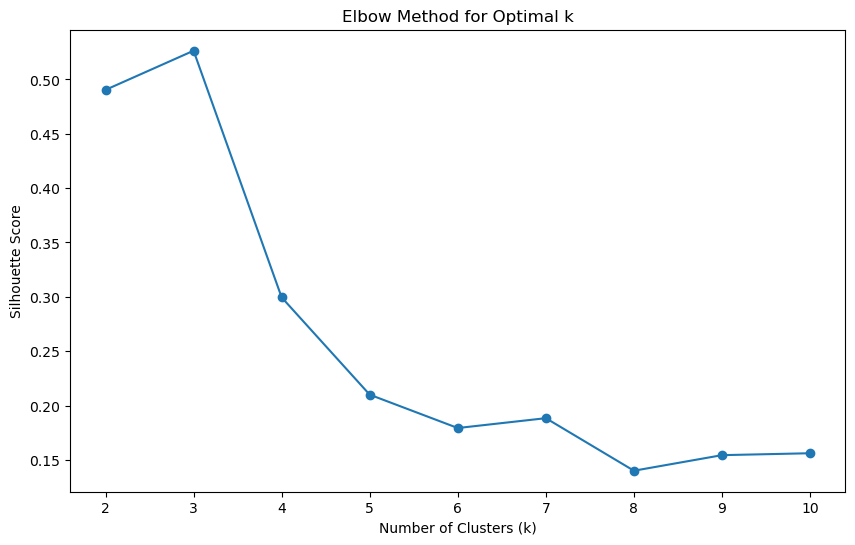

In [29]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Assuming X_scaled is your scaled data
X_scaled = scaled_data

# List to store silhouette scores for different k values
silhouette_scores = []

# Range of k values to try
k_values = range(2, 11)

# Iterate over each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=22)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method for Optimal k')
plt.show()

##### simple random forest to identify feature importance

In [30]:
rf = RandomForestClassifier()
rf.fit(X, X['cluster'])
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)
print(feature_importance)
      

cluster                           0.118229
tumor_grade                       0.113219
treatment_or_therapy              0.101344
prior_treatment                   0.093120
synchronous_malignancy            0.069149
last_known_disease_status         0.057852
treatment_type                    0.057152
classification_of_tumor           0.056467
prior_malignancy                  0.054055
icd_10_code                       0.048890
progression_or_recurrence         0.034533
year_of_death                     0.023921
site_of_resection_or_biopsy       0.023798
year_of_diagnosis                 0.022164
age_at_index                      0.021573
year_of_birth                     0.020146
age_is_obfuscated                 0.017800
days_to_diagnosis                 0.016635
ajcc_pathologic_n                 0.015864
morphology                        0.015787
ajcc_pathologic_t                 0.007212
wilms_tumor_histologic_subtype    0.005032
ajcc_pathologic_stage             0.001578
days_to_las

In [31]:
# Analyzing survivability categories within each cluster
cluster_dist = X.groupby(['cluster', 'survivability_category']).size().unstack()

# Assigning survival likelihood based on each cluster
cluster_best = cluster_dist.idxmax(axis=1)
X['survival_likelyhood'] = X['cluster'].map(cluster_best)
print(cluster_dist)

# Display the assigned recommended survival likelihood for each cluster
print(X[['cluster', 'survival_likelyhood']])        

survivability_category    0    1
cluster                         
0                       452  391
1                        27   23
2                        46  111
      cluster  survival_likelyhood
0           0                    0
1           0                    0
10          0                    0
11          0                    0
12          0                    0
...       ...                  ...
5673        0                    0
5700        2                    1
5707        2                    1
5741        0                    0
5742        0                    0

[1050 rows x 2 columns]


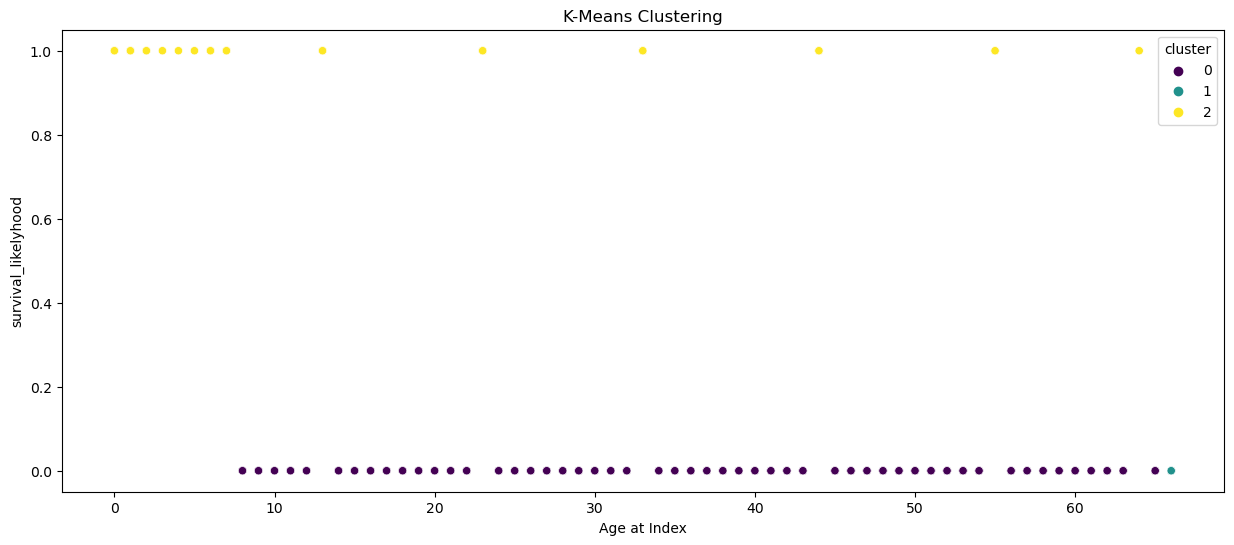

In [32]:
ordered_categories = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
X['ajcc_pathologic_stage'] = pd.Categorical(X['ajcc_pathologic_stage'], categories=ordered_categories, ordered=True)

# Plotting with Seaborn scatterplot
plt.figure(figsize=(15, 6))

# Plot 1: Clustering Information
sns.scatterplot(x='age_at_index', y='survival_likelyhood', hue='cluster', data=X, palette='viridis', legend='full')
plt.title('K-Means Clustering')
plt.xlabel('Age at Index')
plt.ylabel('survival_likelyhood')



plt.show()


## svm to predict which stage of cancer

In [33]:
df_svm = df_gb.copy()

df_svm = df_svm.dropna(subset=['ajcc_pathologic_stage']).copy()

# Define features (X) and target variable (y)
X = df_svm.drop(['ajcc_pathologic_stage', 'case_id', 'case_submitter_id', 'project_id'], axis=1).copy()
y = df_svm['ajcc_pathologic_stage'].copy()

# Convert non-numeric values to strings
X = X.applymap(str)

# Handle categorical variables using OrdinalEncoder
encoder = OrdinalEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(X), columns=X.columns)

# Drop rows with missing values
X_no_missing = X_encoded.dropna()

# Also, make sure to align the target variable (y) accordingly
y_no_missing = y[X.index.isin(X_no_missing.index)]

# Check if there are still missing values in the features
if X_no_missing.isnull().any().any():
    print("Error: Missing values still exist after dropping rows.")
else:
    print("Missing values successfully dropped.")

num_rows_after = X_no_missing.shape[0]


# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_no_missing)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_no_missing, y, test_size=0.2, random_state=42)

features_X = X_train.columns

if X_train.isnull().any().sum() > 0:
    print("Error in imputer: Missing values in X still exist after imputation.")

if y_train.isnull().any().sum() > 0:
    print("Error in imputer: Missing values in y still exist after imputation.")

print(features_X)


Missing values successfully dropped.
Index(['age_at_index', 'age_is_obfuscated', 'days_to_birth', 'days_to_death',
       'ethnicity', 'gender', 'race', 'vital_status', 'year_of_birth',
       'year_of_death', 'age_at_diagnosis', 'ajcc_clinical_m',
       'ajcc_pathologic_m', 'ajcc_pathologic_n', 'ajcc_pathologic_t',
       'ajcc_staging_system_edition', 'classification_of_tumor',
       'days_to_diagnosis', 'days_to_last_follow_up', 'icd_10_code',
       'last_known_disease_status', 'morphology', 'primary_diagnosis',
       'prior_malignancy', 'prior_treatment', 'progression_or_recurrence',
       'site_of_resection_or_biopsy', 'synchronous_malignancy',
       'tissue_or_organ_of_origin', 'tumor_grade',
       'wilms_tumor_histologic_subtype', 'year_of_diagnosis',
       'treatment_or_therapy', 'treatment_type', 'survivability_category'],
      dtype='object')


Accuracy: 87.86%
Classification Report:
              precision    recall  f1-score   support

     Stage I       0.93      1.00      0.97        42
    Stage II       0.92      0.92      0.92        13
   Stage III       0.85      0.80      0.82        55
    Stage IV       0.86      0.86      0.86        63

    accuracy                           0.88       173
   macro avg       0.89      0.90      0.89       173
weighted avg       0.88      0.88      0.88       173



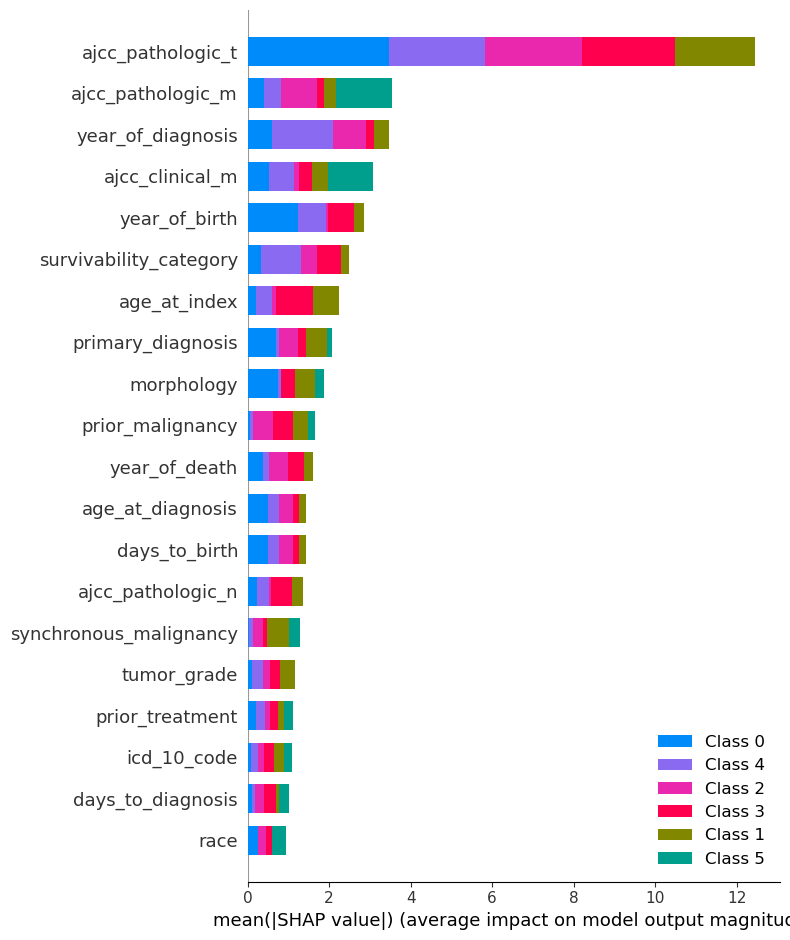

In [34]:
# Standardize the features (optional but often beneficial for SVMscaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM model
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Display additional metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# SHAP analysis
explainer = shap.Explainer(svm_classifier, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)